## RNA-seq analysis
Paper: Genetic and genomic analyses of Drosophila melanogaster models of chromatin modification disorders

# Setup

In [ ]:
import numpy as np
import scipy 
from scipy import stats
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import seaborn as sns
import csv
import os
import sys
import argparse
from time import time
import pandas as pd

import altair as alt
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

In [ ]:
pip install pydeseq2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# Filtering data 

In [ ]:
# Loading files: raw gene counts, description.xlsx
from google.colab import files
uploaded = files.upload()

Saving description.xlsx to description.xlsx
Saving GSE213763_read_counts_forGEO.csv to GSE213763_read_counts_forGEO.csv


In [ ]:
#Read in data
counts = pd.read_csv("GSE213763_read_counts_forGEO.csv", index_col = 0).iloc[:, 1:].T 
counts.index = counts.index.str.replace('_sorted.bam', '')
description = pd.read_excel("description.xlsx", index_col=0)#.index.name=None#.rename(columns = {'sample_name':'Geneid'})#.reset_index(drop=True)#.set_index('Geneid')
description.index.name=None
description['disease'] = np.where(description.gene.str.contains('osa|brm|Snr1'),'SSRIDD','CdLS')
description.iloc[36:42, -1] = 'Control'

In [ ]:
# Convert to log2
counts_log2 = np.log2(counts + 0.5)
counts_log2_values = counts_log2.values.flatten()  # flatten the matrix into a 1D array

In [ ]:
# Histogram for counts
'''
plt.hist(counts_log2_values, bins=50)
plt.title("Histogram of Log2 RNAseq counts")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.show()
'''

'\nplt.hist(counts_log2_values, bins=50)\nplt.title("Histogram of Log2 RNAseq counts")\nplt.xlabel("Counts")\nplt.ylabel("Frequency")\nplt.show()\n'

In [ ]:
#first calculate the mean expression for each gene (remember we did add a small count to zeroes)
mean = np.mean(counts_log2,axis = 0)


#next calculate the variability within each gene
sqrt_std = np.sqrt(counts_log2.std())

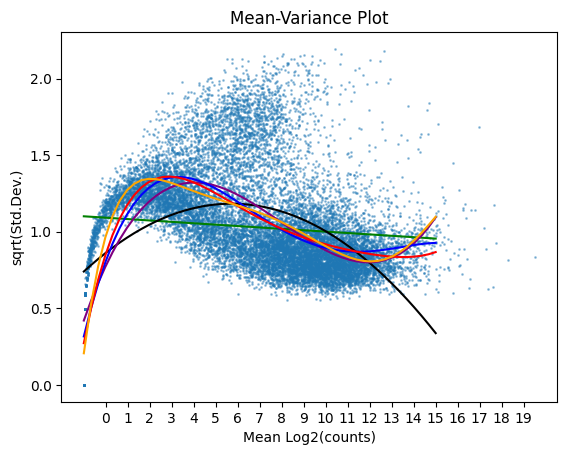

In [ ]:
plt.title("Mean-Variance Plot")
plt.xlabel("Mean Log2(counts)")
plt.ylabel("sqrt(Std.Dev.)") 

#fit polynomial models up to degree 6
model1 = np.poly1d(np.polyfit(mean, sqrt_std, 1))
model2 = np.poly1d(np.polyfit(mean, sqrt_std, 2))
model3 = np.poly1d(np.polyfit(mean, sqrt_std, 3))
model4 = np.poly1d(np.polyfit(mean, sqrt_std, 4))
model5 = np.poly1d(np.polyfit(mean, sqrt_std, 5))
model6 = np.poly1d(np.polyfit(mean, sqrt_std, 6))

#create scatterplot
polyline = np.linspace(-1, 15,50 )
plt.scatter(mean, sqrt_std, alpha=0.4,s = 1)
plt.xticks(np.arange(0, 20, 1))


#add fitted polynomial lines to scatterplot 
plt.plot(polyline, model1(polyline), color='green')
plt.plot(polyline, model2(polyline), color='black')
plt.plot(polyline, model3(polyline), color='purple')
plt.plot(polyline, model4(polyline), color='blue')
plt.plot(polyline, model5(polyline), color='red')
plt.plot(polyline, model6(polyline), color='orange')
plt.show()


In [ ]:
# Set drop off to be at 2 or 3, selected 2
keep_mean = mean > 2

# Filter counts_log2 based on selected threshold log2 counts of 2
counts_log2_filtered = counts_log2.loc[:,keep_mean]
counts_filtered = counts.loc[:,keep_mean]

In [ ]:
# Histogram for filtered counts 
counts_log2_filtered_values = counts_log2_filtered.values.flatten()  # flatten the matrix into a 1D array
'''
plt.hist(counts_log2_filtered_values, bins=50)
plt.title("Histogram of Log2 RNAseq filtered counts")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.show()
'''

'\nplt.hist(counts_log2_filtered_values, bins=50)\nplt.title("Histogram of Log2 RNAseq filtered counts")\nplt.xlabel("Counts")\nplt.ylabel("Frequency")\nplt.show()\n'

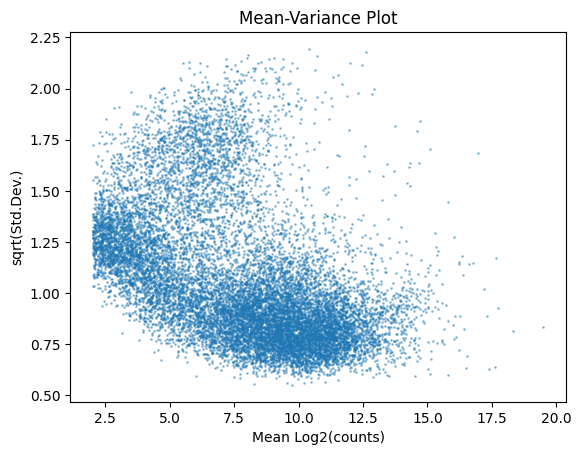

In [ ]:
# Checking filtered scatterplot
mean_filtered = np.mean(counts_log2_filtered,axis = 0)
sqrt_std_filtered = np.sqrt(counts_log2_filtered.std())
plt.scatter(mean_filtered, sqrt_std_filtered, alpha=0.4,s = 1)
plt.title("Mean-Variance Plot")
plt.xlabel("Mean Log2(counts)")
plt.ylabel("sqrt(Std.Dev.)") 
plt.show()

# DESEQ analysis

In [ ]:
counts_filtered_w_description = counts_filtered.merge(description, left_index=True, right_index=True)
counts_filtered_w_description.index.name=None

In [133]:
# filtered counts file for clds vs control and ssridd vs control 
ssridd_control = counts_filtered_w_description.iloc[np.where(counts_filtered_w_description.disease.str.contains('SSRIDD|Control'))].iloc[:,2:15192]
cdls_control = counts_filtered_w_description.iloc[np.where(counts_filtered_w_description.disease.str.contains('CdLS|Control'))].iloc[:,2:15192]

In [134]:

# description file for cdls vs control and ssridd vs control
ssridd_control_descripton = description.iloc[np.where(description.disease.str.contains('SSRIDD|Control'))]
cdls_control_descripton = description.iloc[np.where(description.disease.str.contains('CdLS|Control'))]
ssridd_control_descripton.name=None
cdls_control_descripton.name=None

In [ ]:
def DESeq2Wrapper(counts,meta,comparison):
#Start by initializing the data, using the DeseqDataSet() function. The function requires 3 inputs: 
# the CountsData data frame (containing the gene expression data in counts format), 
# the meta data frame (containing the metadata associated with each sample),
# and the name of the column in meta that contains the group information for which comparison you want to make. To compare normal vs. metastatic, use "Stage" 
  dds = DeseqDataSet(counts = counts, clinical = meta, design_factors=comparison)

  dds.fit_size_factors()
  scaling_deseq = list(dds.obsm["size_factors"])
  dds.fit_genewise_dispersions()

  dds.deseq2()

  dds.calculate_cooks()
  if dds.refit_cooks:
    # Replace outlier counts
    dds.refit()

  CountsNormal = pd.DataFrame(dds.layers['normed_counts'], 
                                     index=dds.obs.index, 
                                     columns=dds.var.index)

  deseq_stats = DeseqStats(dds,alpha = 0.05)
  deseq_stats.summary()
  return CountsNormal, deseq_stats.results_df

In [ ]:
# deseq analys cdls vs control and ssridd vs control
count_normal_ssridd_control, deseq_results_ssridd_control = DESeq2Wrapper(ssridd_control, ssridd_control_descripton, "disease")
count_normal_cdls_control, deseq_results_cdls_control = DESeq2Wrapper(cdls_control, cdls_control_descripton, "disease")

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 23.63 seconds.

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 23.24 seconds.

Fitting dispersion trend curve...
... done in 6.19 seconds.

Fitting MAP dispersions...
... done in 31.71 seconds.

Fitting LFCs...
... done in 12.91 seconds.

Refitting 49 outliers.

Fitting dispersions...
... done in 0.12 seconds.

Fitting MAP dispersions...
... done in 0.12 seconds.

Fitting LFCs...
... done in 0.08 seconds.

Refitting 49 outliers.

Fitting dispersions...
... done in 0.12 seconds.

Fitting MAP dispersions...
... done in 0.11 seconds.

Fitting LFCs...
... done in 0.08 seconds.

Running Wald tests...
... done in 4.47 seconds.

Log2 fold change & Wald test p-value: disease SSRIDD vs Control


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
FBgn0062565,11.775534,-0.440702,0.748096,-0.589099,0.555795,0.999953
FBgn0031088,97.094682,-0.196796,0.331623,-0.593432,0.552892,0.999953
FBgn0041626,14.705366,-1.000519,0.581381,-1.720935,0.085263,0.858619
FBgn0040784,30.267131,0.540011,0.858022,0.629368,0.529108,0.999953
FBgn0031086,28.357845,-0.337504,0.817337,-0.412932,0.679656,0.999953
...,...,...,...,...,...,...
FBgn0031309,199.397147,0.021656,0.369092,0.058674,0.953212,0.999953
FBgn0031305,801.123247,-0.476969,0.438699,-1.087237,0.276932,0.999953
FBgn0016926,7664.963925,-0.002813,0.148772,-0.018911,0.984912,0.999953
FBgn0031299,312.897617,0.329056,0.239753,1.372476,0.169915,0.999953


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 23.01 seconds.

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 24.78 seconds.

Fitting dispersion trend curve...
... done in 5.98 seconds.

Fitting MAP dispersions...
... done in 31.88 seconds.

Fitting LFCs...
... done in 13.46 seconds.

Refitting 8 outliers.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Refitting 8 outliers.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...
... done in 3.67 seconds.

Log2 fold change & Wald test p-value: disease Control vs CdLS


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
FBgn0062565,9.180322,0.977181,0.719383,1.358360,0.174350,0.739926
FBgn0031088,85.160181,0.406432,0.415347,0.978537,0.327809,0.896528
FBgn0041626,17.663868,0.569187,0.641033,0.887922,0.374583,0.916443
FBgn0040784,31.054466,-0.613933,0.848749,-0.723339,0.469472,0.963238
FBgn0031086,25.376055,0.530603,0.659727,0.804276,0.421238,0.943545
...,...,...,...,...,...,...
FBgn0031309,250.604627,-0.520055,0.423936,-1.226732,0.219924,0.793658
FBgn0031305,987.700437,-0.016648,0.250439,-0.066475,0.947000,0.996223
FBgn0016926,7517.132944,-0.019797,0.126921,-0.155982,0.876047,0.992337
FBgn0031299,323.575198,-0.436725,0.297983,-1.465604,0.142756,0.690643


In [ ]:
# Saving ssridd vs control results
count_normal_ssridd_control.to_csv('counts_normal_ssridd_control.csv')
deseq_results_ssridd_control.to_csv('deseq_result2_ssridd_control.csv')

# Saving cdls vs control results
count_normal_cdls_control.to_csv('counts_normal_cdls_control.csv')
deseq_results_cdls_control.to_csv('deseq_result2_cdls_control.csv')

In [ ]:
# Loading files: raw gene counts, description.xlsx
from google.colab import files
uploaded = files.upload()

Saving counts_normal_cdls_control.csv to counts_normal_cdls_control.csv
Saving counts_normal_ssridd_control.csv to counts_normal_ssridd_control.csv
Saving deseq_result2_cdls_control.csv to deseq_result2_cdls_control.csv
Saving deseq_result2_ssridd_control.csv to deseq_result2_ssridd_control.csv


In [ ]:
# Read in deseq results and normalized counts 
# ssridd
ssridd_deseq_results = pd.read_csv('deseq_result2_ssridd_control.csv', index_col = 0)
ssridd_counts = pd.read_csv('counts_normal_ssridd_control.csv', index_col = 0)
ssridd_deseq_results.index.name = None
ssridd_counts_w_description = ssridd_counts.merge(ssridd_control_descripton, left_index=True, right_index=True, how='outer').reset_index().set_index('sample_title')
ssridd_counts_w_description.index.name=None


#clds
cdls_deseq_results = pd.read_csv('deseq_result2_cdls_control.csv', index_col = 0)
cdls_counts = pd.read_csv('counts_normal_cdls_control.csv', index_col = 0)
cdls_deseq_results.index.name = None
cdls_counts_w_description = cdls_counts.merge(cdls_control_descripton, left_index=True, right_index=True, how='outer').reset_index().set_index('sample_title')
cdls_counts_w_description.index.name=None

In [ ]:
# Find the most significant genes from cdls deseq results 
significant_genes = cdls_deseq_results[(cdls_deseq_results['padj'] < 0.05)]
significant_genes_ordered = significant_genes.sort_values(by='log2FoldChange', key=abs, ascending = False)
significant_genes_ordered = significant_genes_ordered.assign(rank=range(len(significant_genes_ordered)))

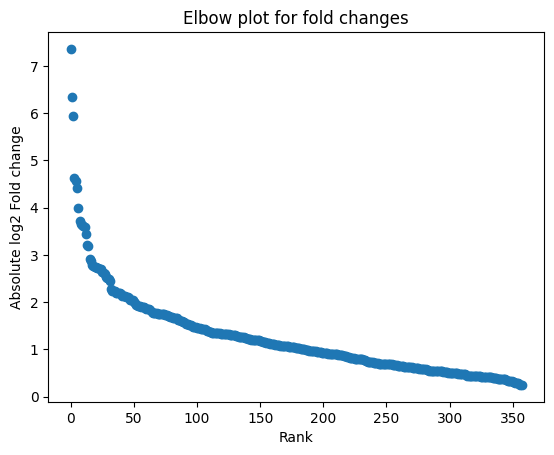

In [ ]:
plt.scatter(significant_genes_ordered['rank'], abs(significant_genes_ordered['log2FoldChange']))
plt.title("Elbow plot for fold changes")
plt.xlabel("Rank")
plt.ylabel("Absolute log2 Fold change")
plt.show()

In [130]:
# Filter and identify gene of interest according to padj and log2fold change threshold
goi = cdls_deseq_results[(cdls_deseq_results['padj'] < 0.05) & (abs(cdls_deseq_results['log2FoldChange']) >= 2)]
goi = goi.sort_values(by = 'log2FoldChange', key=abs, ascending = False)
goi_25 = goi.iloc[:25,]

# Get filtered counts for gene of interst 
'''
goi_counts2 = cdls_counts_w_description.iloc[:,2:15193].loc[:,goi_25.index]
'''

'\ngoi_counts2 = cdls_counts_w_description.iloc[:,2:15193].loc[:,goi_25.index]\n'

In [102]:
counts_filtered_w_description2 = counts_filtered_w_description.reset_index().set_index('sample_title')
counts_filtered_w_description2.index.name=None
#goi_counts = counts_filtered_w_description2.iloc[:,2:15193].loc[:,goi_25.index]

In [135]:
goi_counts = cdls_control.merge(cdls_control_descripton, left_index=True, right_index=True).reset_index().set_index('sample_title')
goi_counts.index.name=None
goi_counts = goi_counts.iloc[:,2:15193].loc[:,goi_25.index]

In [136]:
cdls_control_descripton = cdls_control_descripton.reset_index().set_index('sample_title')
cdls_control_descripton.index.name=None

# Visualization 1: Clustermap for CdLS vs Control

In [149]:
goi_counts_log2 = np.log2(goi_counts + 0.5)
goi_counts_log2_trip_mean = goi_counts_log2.iloc[18:,:].mean()
goi_counts_log2_diff = -(goi_counts_log2 - goi_counts_log2_trip_mean)

In [150]:
diseasetype = set(cdls_control_descripton.disease)
disease_color = dict(zip(diseasetype,sns.color_palette()))
disease = cdls_control_descripton.loc[:,'disease']
row_colors1 = disease.map(disease_color)


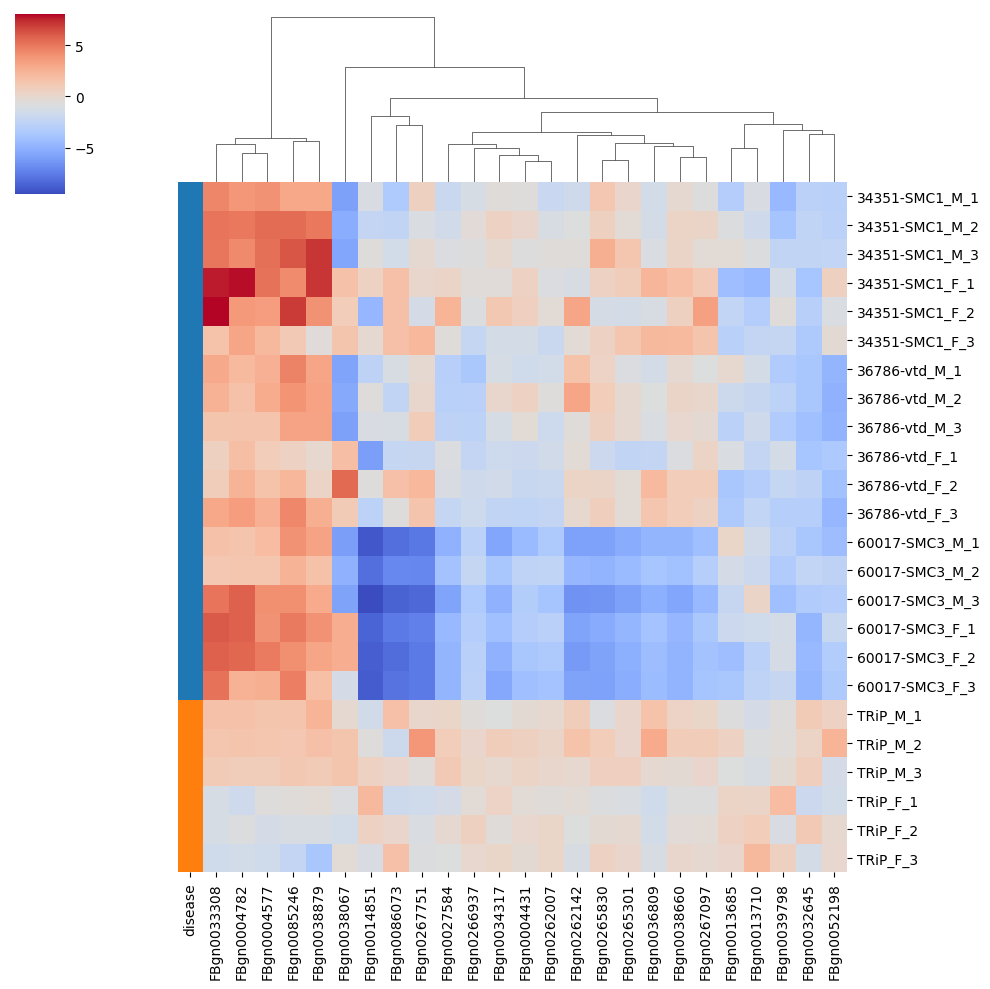

In [152]:
# Comparison between each disease with control 
clustermap = sns.clustermap(goi_counts_log2_diff, row_colors=row_colors1,cmap = 'coolwarm', row_cluster=False)
#clustermap.figure.savefig("clustermap_cdls_control.png")

# Visualization 2: Volcano plot for most significant fold change genes

In [ ]:
cdls_counts = goi_counts
cdls_goi_deseq_result = cdls_deseq_results.loc[cdls_counts.columns]
ssridd_goi_deseq_result = ssridd_deseq_results.loc[cdls_counts.columns]

In [ ]:
cdls_goi_deseq_result['-log10_padj'] = -np.log10(cdls_goi_deseq_result['padj'])
ssridd_goi_deseq_result['-log10_padj'] = -np.log10(ssridd_goi_deseq_result['padj'])

In [ ]:
cdls_goi_deseq_result['padj_significant'] = np.where(cdls_goi_deseq_result['padj'] < 0.05, True, False)
ssridd_goi_deseq_result['padj_significant'] = np.where(ssridd_goi_deseq_result['padj'] < 0.05, True, False)

In [ ]:
cdls_goi_deseq_result = cdls_goi_deseq_result.add_suffix('_cdls')
ssridd_goi_deseq_result = ssridd_goi_deseq_result.add_suffix('_ssridd')

In [ ]:
combined = pd.concat([cdls_goi_deseq_result, ssridd_goi_deseq_result], axis=1).dropna()


In [ ]:
DESeq2Results_AllPairwise = combined
interval = alt.selection_interval(encodings = ['x','y'])

DESeq2Results_AllPairwise_volcano = alt.Chart(DESeq2Results_AllPairwise).mark_point().encode(
    x = "log2FoldChange_cdls",
    y = "-log10_padj_cdls",
    color = alt.condition(interval, "padj_significant_ssridd", alt.value('gray')),

).properties(
    selection = interval
)

DESeq2Results_AllPairwise_volcano | DESeq2Results_AllPairwise_volcano.encode(x = "log2FoldChange_ssridd", y = "-log10_padj_ssridd")

alt.HConcatChart(...)

# Visualization 3: PCA plot

In [ ]:
counts_w_description = counts_filtered.merge(description, left_index=True, right_index=True, how='outer').reset_index().set_index('sample_title')
counts_w_description.index.name=None

In [ ]:
diseasetypes = set(counts_w_description.disease)

In [ ]:
# Convert the data and transform data for PCA 
from   sklearn.decomposition import PCA
from   sklearn.manifold import TSNE
from   sklearn.preprocessing import StandardScaler

In [ ]:
goi_counts = counts_filtered.loc[:,cdls_counts.columns.to_list()]

In [ ]:
goi_counts_scaled = StandardScaler().fit_transform(goi_counts)
goi_pca = PCA().fit(goi_counts_scaled)
goi_pca_data = goi_pca.transform(goi_counts_scaled)

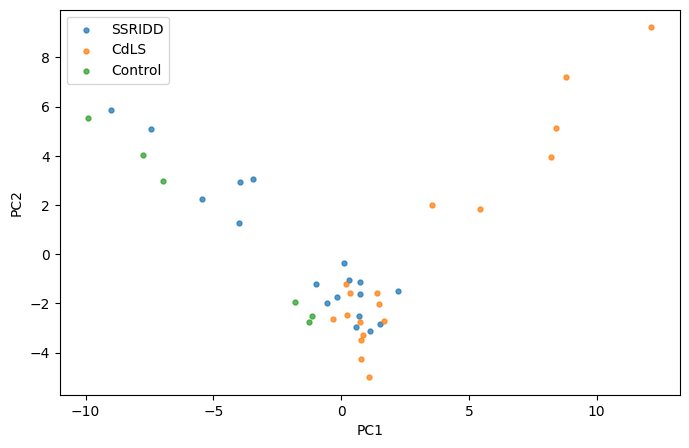

In [ ]:
# Plotting PCA 
fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot(111)

for disease in diseasetypes:
  ax.scatter(goi_pca_data[counts_filtered_w_description['disease'] == disease, 0], 
             goi_pca_data[counts_filtered_w_description['disease'] == disease, 1], 
             alpha=0.75, marker=".", s=50, label=disease)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(loc="best")

In [ ]:
# Genes most strongly associated with PC1
pc1_loadings = goi_pca.components_[0, :].T
pc1_weighted_loadings = pc1_loadings* goi_pca.explained_variance_[0]

gene_names = counts_w_description.iloc[:,2:15194].loc[:,goi.index].columns.values

n_top_genes=1
top_pc1_gene_idxs = np.argsort(np.abs(pc1_weighted_loadings))[-n_top_genes:]
for gene_idx in top_pc1_gene_idxs:
  print(gene_names[gene_idx])
  ax.annotate(text = gene_names[gene_idx],
              xy = [0, 0],
              xytext = [goi_pca.components_.T[gene_idx, 0] * goi_pca.explained_variance_[0], 
                        goi_pca.components_.T[gene_idx, 1] * goi_pca.explained_variance_[1]],
              arrowprops=dict(arrowstyle='<-',linewidth=1, shrinkA=0.9)) 


FBgn0033308


FBgn0036809


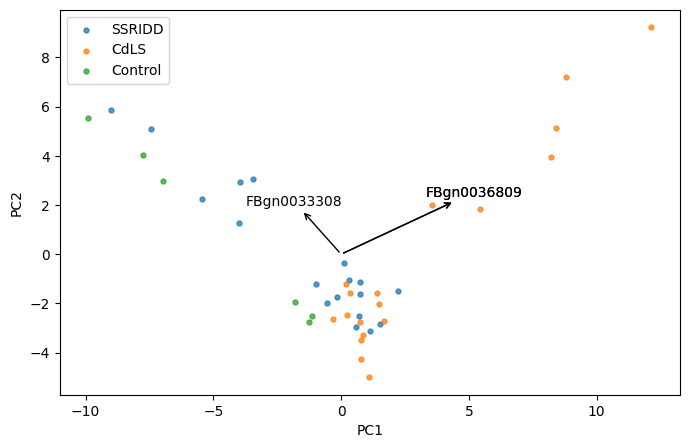

In [ ]:
# Genes most strongly associated with PC1 and PC2 
pc2_loadings = goi_pca.components_[1, :].T
pc2_weighted_loadings = pc2_loadings* goi_pca.explained_variance_[2]


gene_names = counts_w_description.iloc[:,2:15194].loc[:,goi.index].columns.values

n_top_genes=1
top_pc2_gene_idxs = np.argsort(np.abs(pc2_weighted_loadings))[-n_top_genes:]

for gene_idx in top_pc2_gene_idxs:
  print(gene_names[gene_idx])
  ax.annotate(text = gene_names[gene_idx],
              xy = [0, 0],
              xytext = [goi_pca.components_.T[gene_idx, 0] * goi_pca.explained_variance_[0], 
                        goi_pca.components_.T[gene_idx, 1] * goi_pca.explained_variance_[1]],
              arrowprops=dict(arrowstyle='<-',linewidth=1, shrinkA=0.9)) 
  
fig.figure.savefig("PCA_cdls_control.png")
fig

# Most significant genes

In [155]:
goi.sort_values(by='padj')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
FBgn0017448,489.749431,-2.226410,0.103237,-21.566095,3.739624e-103,5.680115e-99
FBgn0260396,880.424108,-2.130750,0.265289,-8.031811,9.604421e-16,3.647039e-12
FBgn0032645,1837.219621,-3.612746,0.459859,-7.856204,3.959516e-15,1.095354e-11
FBgn0053346,152.371059,-2.439645,0.334341,-7.296878,2.945225e-13,6.390718e-10
FBgn0266937,144.106603,-2.713869,0.397429,-6.828569,8.576563e-12,1.447438e-08
FBgn0262007,911.188501,-2.708039,0.399306,-6.781872,1.186283e-11,1.801845e-08
FBgn0039798,125.068740,-2.902611,0.431628,-6.724797,1.758372e-11,2.054454e-08
FBgn0052198,273.623147,-3.580545,0.544766,-6.572627,4.943518e-11,5.363364e-08
FBgn0014851,264.074282,-7.358294,1.203901,-6.112043,9.836368e-10,7.470230e-07
FBgn0266724,696.848999,-2.235590,0.370585,-6.032599,1.613431e-09,1.113928e-06


In [1]:
ssridd_deseq_results.iloc['padj'] < 0.05

NameError: ignored

In [ ]:
ssridd_deseq_results.loc[goi_25.index]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
FBgn0014851,3.286450,0.746014,0.730263,1.021569,3.069851e-01,9.999526e-01
FBgn0086073,2.964341,0.985150,0.827952,1.189864,2.340998e-01,9.999526e-01
FBgn0267751,7.052534,-0.208247,0.502699,-0.414257,6.786856e-01,9.999526e-01
FBgn0038067,311.396461,4.092913,0.909356,4.500894,6.766837e-06,8.596553e-04
FBgn0262142,4.455937,0.221687,0.477934,0.463843,6.427600e-01,9.999526e-01
FBgn0265830,21.049156,-0.363636,0.381962,-0.952022,3.410860e-01,9.999526e-01
FBgn0265301,15.318225,-0.412657,0.322262,-1.280503,2.003683e-01,9.999526e-01
FBgn0034317,102.837647,2.135165,0.369212,5.783025,7.336905e-09,2.321213e-06
FBgn0027584,606.827983,2.186463,0.299060,7.311127,2.649103e-13,2.234960e-10
FBgn0038660,122.279877,0.264736,0.310481,0.852666,3.938447e-01,9.999526e-01


In [ ]:
ssridd_counts_w_description.loc[:,cdls_top_10]

,FBgn0014851,FBgn0086073,FBgn0267751,FBgn0038067,FBgn0262142,FBgn0265830,FBgn0265301,FBgn0034317,FBgn0027584,FBgn0038660
35447-osa_M_1,1.886626,5.659878,10.376443,843.321818,3.773252,14.149695,21.696199,152.816705,588.627309,127.347254
35447-osa_M_2,5.496669,3.664446,8.245004,731.056985,9.161115,10.993338,17.406119,153.906734,778.694784,115.430050
35447-osa_M_3,1.106643,6.639859,5.533216,820.022590,1.106643,8.853145,8.853145,58.652088,938.433410,123.944035
35447-osa_F_1,13.632482,0.000000,3.029441,17.419283,3.786801,38.625367,13.632482,107.545139,667.991639,68.919772
35447-osa_F_2,3.868483,1.547393,5.415876,45.648096,6.189572,23.984593,6.189572,75.822261,341.200173,104.449032
35447-osa_F_3,4.222575,4.222575,4.222575,10.556438,7.389506,26.391094,12.667725,89.729720,800.177970,48.559613
35211-brm_M_1,0.977425,6.841978,6.841978,978.402886,0.000000,6.841978,9.774255,336.234358,757.504732,98.719972
35211-brm_M_2,7.119363,14.238727,8.701444,992.755661,2.373121,29.268494,16.611848,133.685822,444.564686,111.536692
35211-brm_M_3,0.897265,1.794530,13.458973,1138.629131,1.794530,13.458973,11.664443,264.693139,751.907969,69.089396
35211-brm_F_1,9.237199,1.539533,1.539533,18.474397,7.697665,56.962724,30.790662,232.469496,454.162260,72.358055
